#### Importando as bibliotecas e frameworks

In [100]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#### Criando o dataframe inicial com os dados que servirá de base para os experimentos

In [101]:
#carregando o dataframe total
df_inicial = pd.read_csv("healthcare-dataset-stroke-data.csv")
#criando o filtro dos individuos com stroke
filtro = df_inicial['stroke'] == 1
#criando os dfs de atingidos e não atingidos por avcs (sem levar em consideração as linhas com Nan's)
df_avc = df_inicial[filtro].dropna()
df_not_avc = df_inicial[~filtro].dropna()
#encontrando a quantidade de individuos com avc
tamanho_maximo = len(df_avc)
#criando o dataframe inicial com proporções iguais de acometidos e não acometidos pelo avc 
df_not_avc = df_not_avc[:tamanho_maximo]
df = pd.concat([df_avc,df_not_avc])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


#### Separando a coluna de "stroke" e criando uma cópia que será utilizada na hipótese nula.

In [102]:
import copy

df_com_strokes = copy.deepcopy(df)
df_strokes = df.pop("stroke")
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked


#### Formatamos o df para ser utilizado na função de treino do sklearn

In [103]:
#get_dummies quando aplicado em uma coluna de dados binários retorna duas colunas no resultado com os nomes das colunas baseados nos valores únicos presentes na coluna original.
df = pd.get_dummies(df).astype(float)
df_strokes =  df_strokes.replace(0, -1)
#retirando o indice
df = df.drop("id", axis = 1)
#encontrando os maiores valores que serão utilizados para deixar as colunas no range entre 0 a 1
max_age = df['age'].max()
df['age'] = df['age']/max_age
max_glucose = df['avg_glucose_level'].max()
df['avg_glucose_level'] = df['avg_glucose_level']/max_glucose
max_bmi = df['bmi'].max()
df['bmi'] = df['bmi']/max_bmi
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.817073,0.0,1.0,0.841577,0.564815,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.975610,0.0,1.0,0.389784,0.501543,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.597561,0.0,0.0,0.630124,0.530864,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.963415,1.0,0.0,0.640760,0.370370,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,0.987805,0.0,0.0,0.685251,0.447531,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [104]:
# Dvidindo o dataframe em dados para treinamento e dedos para testar
X_train, X_test, y_train, y_test = train_test_split(df, df_strokes, train_size=0.5)


### Árvore de decisão

A árvore de decisão é construída usando o algoritmo de indução de árvores de decisão. O objetivo desse algoritmo é criar uma árvore de decisão que seja capaz de classificar corretamente os exemplos de treinamento e generalizar bem para novos exemplos.

O processo de construção começa com um único nó, que representa todo o conjunto de dados de treinamento. Em seguida, o algoritmo escolhe a melhor variável (ou atributo) para dividir o conjunto de dados em dois subconjuntos, de forma que a pureza da separação seja maximizada.

A pureza da separação é medida usando uma métrica de impureza, que pode ser a entropia ou o índice de Gini, no nosso exemplo é utilizada a entropia como critério. O objetivo é escolher a variável que resulta na maior redução da impureza dos subconjuntos.

Esse processo de escolher a melhor variável e dividir o conjunto de dados em subconjuntos é repetido recursivamente para cada subconjunto, até que os subconjuntos resultantes sejam completamente puros ou até que um critério de parada seja atingido (por exemplo, uma profundidade máxima da árvore ou um número mínimo de exemplos por nó).

Ao final do processo de construção, a árvore resultante é composta por nós que representam as variáveis e as decisões tomadas com base nelas, bem como por folhas que representam as classes preditas para cada subconjunto de exemplos.

Acurácia: 69.85645933014354 %
As duas principais features desse experimento foram ('age', 'bmi')


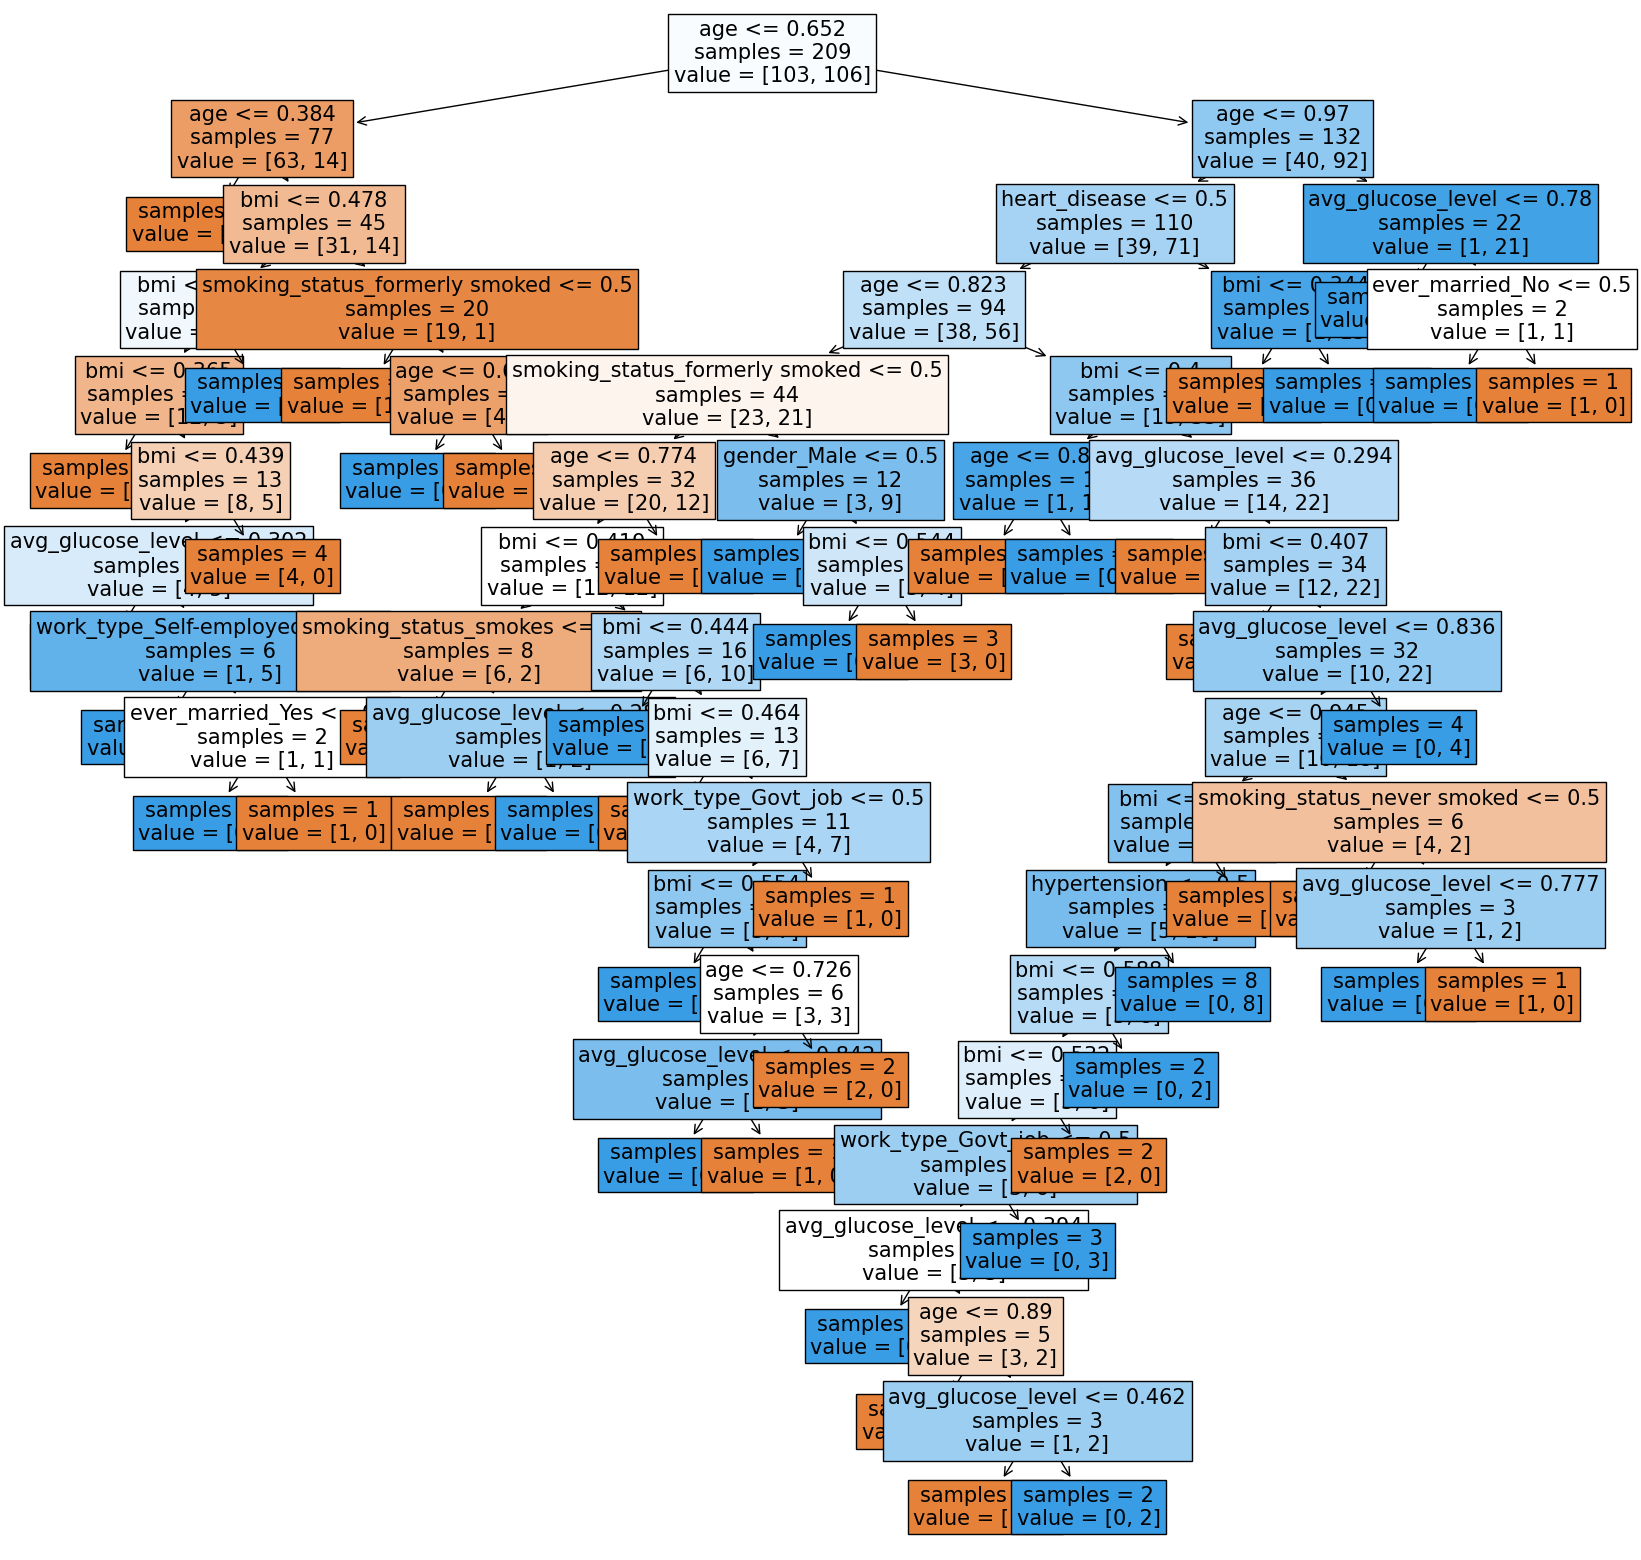

In [105]:
import math
#função que encontra no dataframe as duas features mais importantes
def return_most_important_features(lista_features, df):
    lista_ids = []
    for i in range(2):
        maior = -math.inf
        id_maior = 0
        for feature in range(len(lista_features)):
            if lista_features[feature] > maior:
                maior = lista_features[feature]
                id_maior = feature
        lista_features[id_maior] = 0
        lista_ids.append(id_maior)
    l1 = df.columns[lista_ids[0]]
    l2 = df.columns[lista_ids[1]]
    return f"As duas principais features desse experimento foram {(l1,l2)}"

#instância da árvore
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train, y_train)

# Faça previsões nos dados de teste usando a árvore treinada
y_pred = tree.predict(X_test)

# Calcule a acurácia das previsões
acc_tree = accuracy_score(y_test, y_pred)
print("Acurácia:", acc_tree*100, "%")
#Permite a vizualização das features mais importantes para essa classificação
lista_importancias = tree.feature_importances_
#retorna as duas principais features
print(return_most_important_features(lista_importancias,df))

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

#representação gráfica da árvore
plt.figure( figsize=(20,20) )
a = plot_tree(tree, feature_names=df.columns, fontsize=15, 
              node_ids=False, impurity=False, filled=True)

# Abordagem Matemática utilizada : 

Partindo da formulação :

$$
f(x,y) = Ax + By + C
$$

Nessa formulação, estamos assumindo que nossa entrada tem duas dimensões ($x$ e $y$).

Veja como $f(x,y)$ funciona como se $A$ fosse o "peso" atribuído a $x$, e $B$ é o "peso" atribuído a $y$. $C$ é uma variável que nos dá uma tendência que é independente das entradas.

Dessa forma, podemos partir para uma formulação matricial do problema e estender para $N$ dimensões ao invés de apenas $2$.

Assim, podemos assumir que nossa entrada tem $N$ dimensões, expressas em um vetor-coluna $\boldsymbol x$. Nesse caso, os coeficientes do nosso classificador devem ser colocados também em um vetor-coluna $\boldsymbol w$, e então ficamos com:

$$
f(\boldsymbol x) = b + \sum_n w_n x_n = \begin{bmatrix} w_0 & w_1 & ... & w_{N-1} \end{bmatrix} \begin{bmatrix} x_0 \\ x_1 \\ ... \\ x_{N-1} \end{bmatrix} + b = \boldsymbol w^T \boldsymbol x + b
$$


Portando, vamos trabalhar com essa formulação no problema apresentado já que temos mais de uma dimensão para representar:

In [106]:
# Transformando os dataframes em numpy arrays para poder realizar as operações, além de tranformar todos os valores para float para evitar erros de casting.

X_train = X_train.to_numpy().T
y_train = y_train.to_numpy()


X_train  = X_train.astype(float)
y_train  = y_train.astype(float)


X_test = X_test.to_numpy().T
y_test = y_test.to_numpy()


X_test  = X_test.astype(float)
y_test  = y_test.astype(float)

print(y_test.shape)

(209,)


In [107]:
# Definindo a função de acurácia que verifica o sinal dos valores estimados com os sinais dos valores reais de teste a fim de verificar com foi feita a classificação.
def accuracy(y_test, y_est):
    return np.mean(np.sign(y_test)==np.sign(y_est))


import autograd.numpy as np_   # Thinly-wrapped version of Numpy
from autograd import grad

def loss( parametros ):
    w, b, pontos, val = parametros
    est = w.T @ pontos + b
    mse = np_.mean( (est - val)**2)      #Calculando erro quadrático médio.
    return mse

g = grad(loss)

pontos = X_train
alvos = y_train

w = np.random.randn( 20, 1)  #Criando valores iniciais aleatórios para os pesos do vetor W.
b = np.random.randn()       #Criando valor aleatório para o peso b.
alpha = 10**-4

for n in range(200000):     #Simulando 200000 e fazendo os vetores w e b "andarem" no sentido oposto ao gratiente da função de erro a fim de encontrar um hiperplano que classifique bem os valores dos nossos dados.

    grad_ = g( (w, b, pontos, alvos) ) #Calculando o gradiente
    w -= alpha*grad_[0]  # Dando um passo alpha no sentido oposto.
    b -= alpha*grad_[1]

print(w)
print(b)
print(len(grad_))

[[ 0.9190167 ]
 [ 0.39930611]
 [ 0.4430855 ]
 [ 0.16617991]
 [-0.55342477]
 [-0.10332544]
 [-0.09535487]
 [-0.36302379]
 [-0.24766972]
 [-0.23074838]
 [ 0.69811888]
 [-0.22390424]
 [-0.07297578]
 [-0.62765508]
 [-0.17478583]
 [-0.12700904]
 [-0.0357648 ]
 [ 0.24397858]
 [ 0.06301689]
 [ 0.22942649]]
0.03982157246259756
4


In [116]:
import itertools
#Estimando valores para y a partir dos dados de teste e posterioemnte usando a função de acurácia a para comparar os resultados estimados com  os reais.
y_est = w.T @ X_test + b
acc_classificador = f"{accuracy(y_test, y_est)*100} %" 
print(f"Taxa de acertividade da hipótese do nosso classificador: {acc_classificador}") 
print(return_most_important_features(list(itertools.chain(*w)), df))

Taxa de acertividade da hipótese do nosso classificador: 74.64114832535886 %
As duas principais features desse experimento foram ('age', 'work_type_Never_worked')


#### Hipótese nula

Por fim podemos comparar a eficácia de uma hipótese nula

In [110]:
#Levando em consideração o df que será utilizado nos experimentos que é composto por metade de pessoas que tiveram avc e metade de pessoas que não tiveram, 
#podemos escolher qualquer um dos casos para servir como a hipotese nula (utilizei os doentes como base).

quantidade_de_atingidos_por_avc_teorico = len(df_com_strokes)
filtro_atingidos = df_com_strokes['stroke'] == 1
df_atingidos_avc = df_com_strokes[filtro_atingidos]
quantidade_de_atingidos_por_avc_real = len(df_atingidos_avc)
acertividade = f"{(quantidade_de_atingidos_por_avc_real/quantidade_de_atingidos_por_avc_teorico)*100} %"
print(f"Taxa de acertividade da hipótese nula: {acertividade}")
print(f"Taxa de acertividade da hipótese do nosso classificador: {acc_classificador}")
print(f"Taxa de acertividade da hipótese da árvore de decisão: {acc_tree*100}%")



Taxa de acertividade da hipótese nula: 50.0 %
Taxa de acertividade da hipótese do nosso classificador: 74.64114832535886 %
Taxa de acertividade da hipótese da árvore de decisão: 69.85645933014354%


#### Relação entre os resultados obtidos e artigos científicos.

A partir dos experimentos realizados acima, podemos concluir que alguns fatores possuem maior participação na presença de AVCs, os dois principais encontrados são a idade e as relações de trabalho e com base nos artigos "Age-Related Differences in Characteristics, Performance Measures, Treatment Trends, and Outcomes in Patients With Ischemic Stroke" e "Long Working Hours and Risk of Cardiovascular Disease", podemos demomstrar esses resultados encontrados. O primeiro artigo comprova a relação entre a idade e o risco de AVC, evidenciando que a idade é um fator de risco significativo, segundo o artigo para cada 10 anos sucessivos após os 55 anos de idade, a taxa de AVC mais que dobra tanto em homens quanto em mulheres. Estudos populacionais indicam que 65% de todos os AVCs ocorrem em indivíduos com mais de 65 anos de idade. Já o segundo artigo demonstra por meio de estudos epidemiológicos e experimentais que as condições de trabalho podem contribuir para o desenvolvimento de problemas cardiovasculares, incluindo o AVC.

Link dos artigos utilizados: 

1. Age-Related Differences in Characteristics, Performance Measures, Treatment Trends, and Outcomes in Patients With Ischemic Stroke (https://www.ahajournals.org/doi/10.1161/circulationaha.109.892497#:~:text=Age%20is%20the%20most%20important,stroke%20types%2C%20including%20ischemic%20stroke.&text=For%20each%20successive%2010%20years,in%20both%20men%20and%20women.&text=Population-based%20studies%20indicated%20that,individuals%20>65%20years%20of%20age).

2. Long Working Hours and Risk of Cardiovascular Disease (https://link.springer.com/article/10.1007/s11886-018-1049-9)